In [ ]:
#Importo il modulo drive fornito da Colab per interagire con Google Drive.
from google.colab import drive

#Monta Google Drive nella directory locale /content/drive con stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 64,       #Campioni per batch.
    "n_workers": 2,         #Worker del DataLoader per prefetch/parallelo.
    "max_seq_len": 1024,    #Lunghezza massima; testi lunghi verranno troncati, corti paddati con <pad>.

    # PARAMETRI DEL MODELLO (TextCNN):
    "embedding_dim": 256,             #Più dimensione embedding per capacità semantica.
    "cnn_num_filters": 256,           #Più numero filtri per finestra conv.
    "cnn_kernel_sizes": [3,4,5,7],    #Aggiunto kernel più largo (7) per frasi lunghe.
    "mlp_hidden_dim": 256,            #Più Neuroni nel layer MLP.
    "output_dim": 2,                  #Classi: 0 = Human, 1 = GenAI.
    "dropout": 0.2,                   #Dropout più leggero per non underfittare.

    # PARAMETRI DI TRAINING:
    "learning_rate": 5e-4,            #LR più piccolo per training stabile.
    "epochs": 20,                     #Più epoche (con early stopping).
    "weight_decay": 1e-5,             #Penalità L2 più lieve.
    "label_smoothing": 0.05,          #Smoothing CE (calibrazione).

    # VALIDAZIONE / EARLY STOP:
    "val_size": 0.2,              #Quota validation sul training set.
    "patience": 5                 #Early stopping più paziente.
}

In [ ]:
# STANDARD LIBRARY:
import os                         #Interazione con il file system.
import math                       #Funzioni matematiche base.
import copy                       #Copie profonde/shallow di oggetti.
import re                         #Espressioni regolari (regex).
import random                     #Generatore di numeri casuali.
from collections import Counter   #Conta frequenze di elementi.

# NUMERICO / TABELLARE:
import numpy as np               #Calcolo numerico vettoriale/matriciale.
import pandas as pd              #Strutture tabellari (DataFrame).

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici base.
import seaborn as sns            #Grafici statistici (es. heatmap).

# PROGRESS BAR:
from tqdm.notebook import tqdm   #Barra di avanzamento elegante per loop.

# PyTorch:
import torch                                              #Tensori, GPU, operazioni autograd.
import torch.nn as nn                                     #Moduli per costruire reti neurali.
import torch.nn.functional as F                           #Funzioni di attivazione, loss, etc.
from torch.utils.data import Dataset, DataLoader, Subset  #Gestione dataset e batching.
from torch.cuda.amp import autocast, GradScaler           #Mixed precision training (accelerazione su GPU).

# SCIKIT-LEARN:
from sklearn.model_selection import train_test_split      #Split training / validation.
from sklearn.metrics import (
    accuracy_score,                             #Accuratezza.
    balanced_accuracy_score,                    #Accuratezza bilanciata per classi sbilanciate.
    f1_score,                                   #F1-score.
    precision_recall_fscore_support,            #Precision, recall, f1 per classe.
    confusion_matrix,                           #Matrice di confusione.
    classification_report                       #Report testuale completo.
)

In [ ]:
#Se hai una GPU NVIDIA disponibile e PyTorch con build CUDA, usa "cuda:0".
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"[LOG] Device → {device}")

[LOG] Device → cpu


In [ ]:
def collate_trim(batch):
    """
    Collate function personalizzata per NLP con sequenze padded.
    Rimuove il padding tagliando tutte le sequenze del batch alla lunghezza massima effettiva (senza 0).

    Input: lista di tuple (x: [T_max], y: int)
    Output:
      - xs_trim: tensore [B, L_batch] trimmato
      - ys: etichette [B]
    """
    xs, ys = zip(*batch)
    lens = [int((x != 0).sum().item()) for x in xs]           #Lunghezze reali.
    Lb = max(1, max(lens)) if lens else 1                     #Max lunghezza reale.
    xs_trim = torch.stack([x[:Lb] for x in xs])               #Troncamento dinamico.
    ys = torch.stack(ys)
    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader con:
      - collate_fn = collate_trim (dynamic padding)
      - pin_memory per trasferimenti GPU più rapidi
      - persistent_workers + prefetch_factor (se n_workers > 0)
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True
        kwargs["prefetch_factor"] = 4           #Più batch prefetchati per ridurre attese I/O.
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),
        collate_fn=collate_trim,
        **kwargs
    )

In [ ]:
PAD, UNK = "<pad>", "<unk>"                             #Token speciali: <pad> (id 0) e <unk> (id 1) riservati.
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)    #Regex Unicode: cattura parole alfanumeriche tra confini di parola.

def basic_tokenizer(text: str):                         #Funzione di tokenizzazione minimal basata su regex.
    return _token_re.findall(str(text).lower())         #Lowercase + estrazione dei token; punteggiatura rimossa.

def build_vocab(text_iter, min_freq: int = 1):          #Costruisce il vocabolario da un iterabile di righe di testo.
    counter = Counter()                                 #Multinsieme di frequenze dei token.
    for line in text_iter:                              #Passata unica su tutte le righe.
        counter.update(basic_tokenizer(line))           #Aggiunge i token della riga al contatore.
    vocab = {PAD: 0, UNK: 1}                            #Inizializza il mapping con gli ID riservati.
    for tok, c in counter.most_common():                #Scorre i token per frequenza decrescente.
        if c >= min_freq:                               #Soglia minima di frequenza (filtra rumore/rari).
            vocab[tok] = len(vocab)                     #Assegna ID progressivo corrente.
    return vocab

In [ ]:
class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None):  #Estende torch.utils.data.Dataset.
        df = pd.read_csv(csv_path)                                 #1) Carica il CSV in un DataFrame;
        self.texts  = df["text"].astype(str).tolist()              #2) Colonna 'text' --> lista di stringhe;
        self.labels = df["label"].astype(int).tolist()             #3) Colonna 'label' --> lista di int;
        self.vocab  = vocab or build_vocab(self.texts)             #4) Usa vocabolario passato, altrimenti ne viene costruito uno da zeo.

    def __len__(self):                                             #Obbligatorio, per la lunghezza del dataset.
        return len(self.labels)

    def encode(self, text: str):                                             #Converte stringa in tensor di ID.
        ids = [self.vocab.get(t, self.vocab[UNK])                            #1) token --> id (UNK se assente);
               for t in basic_tokenizer(text)][: global_var["max_seq_len"]]  #2) Tronca a max_seq_len;
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))    #3) pad fino a max_seq_len;
        return torch.tensor(ids, dtype=torch.long)                           #4) Restituisce tensor long [T].

    def __getitem__(self, idx):                                    #Obbligatorio, per l'item i-esimo.
        return self.encode(self.texts[idx]), \
               torch.tensor(self.labels[idx])

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)                          #Seed per il RNG della stdlib Python.
    np.random.seed(seed)                       #Seed per NumPy (operazioni vettoriali).
    torch.manual_seed(seed)                    #Seed per PyTorch su CPU.
    torch.cuda.manual_seed_all(seed)           #Seed per tutte le GPU CUDA (se presenti).
    #Modalità deterministica per cuDNN: risultati ripetibili, a scapito di alcune ottimizzazioni.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)                   #Fissa tutti i generatori per ripetibilità.

# PERCORSI DEI DATASET (CSV):
TRAIN_CSV = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_train_art&mh.csv"
EVAL_CSV  = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_eval_art&mh.csv"   # ← VALIDATION (30)
TEST_CSV  = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_test_art&mh.csv"   # ← TEST (60)

# 1) VOCABOLARIO SOLO SUL TRAIN (no leakage)
full_train = TextDataset(TRAIN_CSV)
vocab = full_train.vocab
print(f"[LOG] Vocabulary size (from TRAIN): {len(vocab)}")

# 2) DATASET DI VALIDATION E TEST (riusano il vocab del TRAIN)
eval_dataset = TextDataset(EVAL_CSV, vocab=vocab)   # 30 esempi
test_dataset = TextDataset(TEST_CSV, vocab=vocab)   # 60 esempi

# 3) DATALOADER (niente split dal train)
train_loader = make_loader(full_train,   global_var["batch_size"], shuffle=True)
val_loader   = make_loader(eval_dataset, global_var["batch_size"], shuffle=False)
test_loader  = make_loader(test_dataset, global_var["batch_size"], shuffle=False)

# (opzionale) sanity check
import pandas as pd
print("[CHECK] VALIDATION rows =", len(pd.read_csv(EVAL_CSV)))
print("[CHECK] TEST rows =", len(pd.read_csv(TEST_CSV)))
assert len(eval_dataset) == 30, "Mi aspetto 30 in VALIDATION"
assert len(test_dataset) == 60, "Mi aspetto 60 in TEST"

[LOG] Vocabulary size (from TRAIN): 2641
[CHECK] VALIDATION rows = 30
[CHECK] TEST rows = 60


In [ ]:
class TextCNN(nn.Module):
    """
    TextCNN potenziata con:
      - Conv1D parallele (kernel multipli)
      - Global Max Pooling
      - MLP con ReLU e Dropout
    """
    def __init__(self,
                 vocab_size: int,             #Numero di token unici nel vocabolario.
                 emb_dim: int,                #Dimensione vettori embedding.
                 num_filters: int,            #Numero di filtri per ciascun kernel.
                 kernel_sizes: list[int],     #Dimensioni kernel convoluzionali.
                 mlp_hidden_dim: int,         #Dimensione del layer MLP nascosto.
                 num_classes: int,            #Numero di classi finali (output).
                 dropout: float = 0.2,        #Probabilità di dropout.
                 padding_idx: int = 0):       #Indice per <PAD>, escluso dalla training.
        super().__init__()

        #Embedding layer con padding_idx che "freeza" il vettore del token <PAD>.
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=padding_idx)

        #Lista di convoluzioni 1D parallele, una per ogni kernel size.
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=emb_dim,          #Canali in ingresso = dimensione embedding.
                out_channels=num_filters,     #Ogni kernel genera num_filters feature-map.
                kernel_size=k                 #Lunghezza del kernel.
            )
            for k in kernel_sizes
        ])

        #Dimensione del vettore concatenato dopo pooling.
        conv_out_dim = num_filters * len(kernel_sizes)

        #Primo layer fully-connected (MLP).
        self.fc1 = nn.Linear(conv_out_dim, mlp_hidden_dim)

        #Secondo layer fully-connected (logits output).
        self.fc2 = nn.Linear(mlp_hidden_dim, num_classes)

        #Dropout layer per regolarizzazione.
        self.drop = nn.Dropout(dropout)

        #ReLU come funzione di attivazione.
        self.act  = nn.ReLU()

    def forward(self, x):
        #Input: x ∈ [B, T], dove 0 = token <PAD>.

        emb = self.embedding(x)                 #[B, T, E] --> embedding dei token.
        emb = emb.transpose(1, 2)               #[B, E, T] --> per compatibilità con Conv1D.

        pooled = []                             #Lista dei vettori pooled da ciascun ramo.

        for conv in self.convs:
            h = self.act(conv(emb))             #[B, F, T'] --> convoluzione e ReLU.
            p = torch.amax(h, dim=2)            #[B, F] --> global max pooling sulla dimensione T'.
            pooled.append(p)                    #Salva output del ramo.

        feat = torch.cat(pooled, dim=1)          #[B, F * n_kernels] --> concatenazione dei rami.

        h = self.drop(self.act(self.fc1(feat)))     #[B, H] --> MLP e ReLU e Dropout.
        h = self.drop(h)                            #Ulteriore dropout (stacked).
        logits = self.fc2(h)                        #[B, K] --> output finale (logits).

        return logits

In [ ]:
# VALUTAZIONE SBILANCIAMENTO DEL DATASET DI TRAINING:
cnt = Counter(full_train.labels)
tot = len(full_train)
imbalance = abs(cnt[0]-cnt[1]) / max(1, tot)
# DEFINIZIONE DELLA FUNZIONE DI LOSS CON SMOOTHING E PESI DI CLASSI, LADDOVE SERVISSE:
if imbalance < 0.05:
    print("[LOG] Dataset bilanciato → niente class weights")
    loss_fn = nn.CrossEntropyLoss(label_smoothing=global_var["label_smoothing"])
else:
    print("[LOG] Train sbilanciato → uso class weights")
    w = torch.tensor([tot/cnt[0], tot/cnt[1]], dtype=torch.float, device=device)
    loss_fn = nn.CrossEntropyLoss(weight=w, label_smoothing=global_var["label_smoothing"])

# ISTANZIA IL MODELLO TextCNN CON PARAMETRI GLOBALI:
model = TextCNN(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    num_filters=global_var["cnn_num_filters"],
    kernel_sizes=global_var["cnn_kernel_sizes"],
    mlp_hidden_dim=global_var["mlp_hidden_dim"],
    num_classes=global_var["output_dim"],
    dropout=global_var["dropout"],
    padding_idx=0
).to(device)

# OTTIMIZZATORE E SCHEDULER PER IL LEARNING RATE:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=global_var["learning_rate"],
    weight_decay=global_var["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

# FUNZIONE DI TRAINING CON AMP, SCHEDULER, EARLY STOPPING:
def train_amp(model, train_loader, val_loader, epochs, patience=5):
    """
    Loop di training con:
    - AMP (automatic mixed precision)
    - gradient clipping
    - ReduceLROnPlateau scheduler
    - early stopping basato su val-loss
    """
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type == "cuda"))
    history = {"train": [], "val": []}
    best_val = math.inf
    best_state = None
    bad = 0

    #Si prova a compilare il modello.
    try:
        if hasattr(torch, "compile"):
            model = torch.compile(model)
    except Exception:
        pass  #Fallback safe.

    for ep in range(epochs):
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")
        for bx, by in pbar:
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)

            #Forward con autocast (mixed precision).
            with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
                logits = model(bx)           #Output del modello [B, K].
                loss = loss_fn(logits, by)   #Loss con smoothing (e pesi se sbilanciato).

            scaler.scale(loss).backward()     #Backward con AMP
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  #Clipping.
            scaler.step(optimizer)
            scaler.update()

            running += loss.item()
            pbar.set_postfix(loss=running / (pbar.n + 1))

        # VALIDAZIONE:
        model.eval()
        val_loss = 0.0
        with torch.inference_mode(), torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                val_loss += loss_fn(model(bx), by).item()
        val_loss /= max(1, len(val_loader))

        # SALVATAGGIO STORICO PERDITE:
        history["train"].append(running / max(1, len(train_loader)))
        history["val"].append(val_loss)
        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.4f} | val={val_loss:.4f}")

        scheduler.step(val_loss)

        # EARLY STOPPING (con salvataggio best weights):
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.4f}).")
                break

    # RICARICA IL MIGLIOR MODELLO:
    if best_state is not None:
        model.load_state_dict(best_state)
    return history

# ESECUZIONE DEL TRAINING:
history = train_amp(
    model, train_loader, val_loader,
    global_var["epochs"],
    patience=global_var["patience"]
)

[LOG] Dataset bilanciato → niente class weights


Epoch 1/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

W0916 19:51:00.352000 8483 torch/utils/cpp_extension.py:118] [0/0] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


[LOG] Ep1: train=1.0777 | val=0.7526


Epoch 2/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep2: train=0.4867 | val=0.6506


Epoch 3/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep3: train=0.2812 | val=0.6722


Epoch 4/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.2167 | val=0.6355


Epoch 5/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.1755 | val=0.6361


Epoch 6/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.1338 | val=0.6215


Epoch 7/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep7: train=0.1318 | val=0.6284


Epoch 8/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep8: train=0.1294 | val=0.6390


Epoch 9/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep9: train=0.1282 | val=0.6472


Epoch 10/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep10: train=0.1312 | val=0.6362


Epoch 11/20 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep11: train=0.1265 | val=0.6309
[LOG] Early stop a epoca 11 (best val=0.6215).


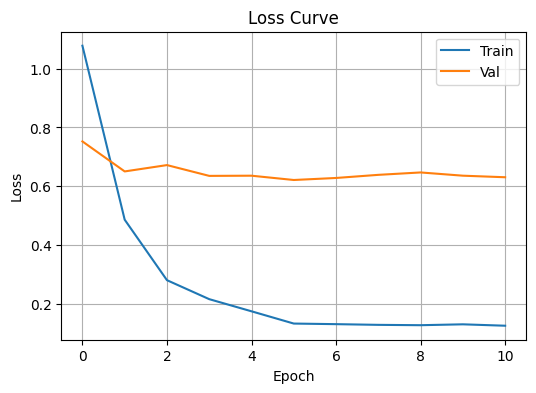

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(history["train"], label="Train")
plt.plot(history["val"],   label="Val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")
plt.legend(); plt.grid(True); plt.show()

In [ ]:
def evaluate_loader(model, loader, label_names=("HUMAN", "GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """
    Valutazione di un modello su un DataLoader.
    Supporta temperature scaling, soglia custom e visualizzazione confusion matrix.
    """
    model.eval()                      #Modalità valutazione.
    y_true, y_pred = [], []

    with torch.inference_mode():      #No gradienti.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature         #Softmax scaling.

            if threshold is None:
                pred = logits.argmax(1).cpu().numpy()           #Classico argmax.
            else:
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()         #Probabilità classe 1.
                pred = (p1 >= threshold).astype(int)                      #Threshold manuale.

            y_pred.extend(pred)
            y_true.extend(by.cpu().numpy().tolist()) # Convert to list to avoid numpy deprecation warning

    # CALCOLO DELLE METRICHE:
    report = classification_report(
        y_true, y_pred, target_names=list(label_names),
        output_dict=True, digits=4
    )
    cm = confusion_matrix(y_true, y_pred)

    # VISUALIZZAZIONE DELLA MATRICE DI CONFUSIONE, SE RICHIESTO:
    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(ttl)
        plt.tight_layout()
        plt.show()

    return report, cm

In [ ]:
def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN", "GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """
    Wrapper di valutazione da un file CSV. Crea il dataset e richiama evaluate_loader.
    """
    batch_size = batch_size or global_var["batch_size"]
    ds = TextDataset(csv_path, vocab=vocab)
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)  #Report, matrice, numero di campioni.

[VAL] temperatura ottima T=0.947
[VAL] soglia ottima t*=0.35 (bal_acc=0.737, f1_macro=0.733, acc=0.733)


/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


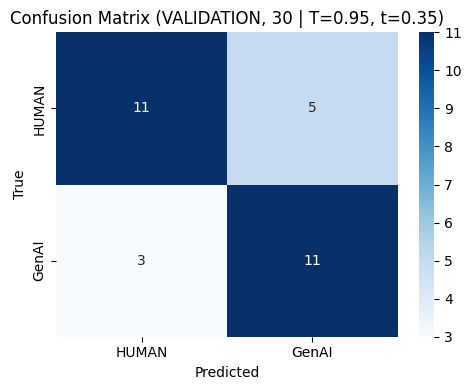


[LOG] Validation su dt_eval_art&mh.csv — campioni: 30
Accuracy: 0.7333  |  F1 macro: 0.7333  |  Precision macro: 0.7366  |  Recall macro: 0.7366


In [ ]:
# 1) CALIBRAZIONE DELLE PROBABILITA' (ottimizza la temperatura T su validation):
def calibrate_temperature(model, val_loader, device):
    model.eval()                                          #Modalità eval: disabilita dropout/batchnorm.
    logits_list, labels_list = [], []                     #Accumulatori per logits e label su tutta la VAL.
    with torch.inference_mode():                          #No grad, mem/compute più leggeri nel loop.
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))      #Forward --> logits [B,C].
            labels_list.append(by.to(device))             #Salva etichette corrispondenti [B].
    logits = torch.cat(logits_list)                       #[N,C] tutti i logits di VAL.
    labels = torch.cat(labels_list)                       #[N]   tutte le label di VAL.

    nll = nn.CrossEntropyLoss()                                     #NLL su logits non normalizzati.
    logT = torch.tensor(0.0, device=device, requires_grad=True)     #Param: logT.
    optimizer = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)      #L-BFGS per unidimensionale.

    def closure():
        optimizer.zero_grad()                             #Richiesto da L-BFGS.
        T = torch.exp(logT)                               #Temperatura positiva.
        loss = nll(logits / T, labels)                    #NLL con scaling dei logits.
        loss.backward()                                   #Gradiente rispetto a logT.
        return loss

    optimizer.step(closure)                               #Esegue le iterazioni L-BFGS.
    T = torch.exp(logT).item()                            #Estrae T scalare (float).
    print(f"[VAL] temperatura ottima T={T:.3f}")          #Log del valore trovato.
    return T

# 2) TUNING SOGLIA SU VALIDATION (usando T):
def tune_threshold_on_val(model, val_loader, device, temperature=1.0, metric="balanced_accuracy"):
    model.eval()                                                  #Eval per disattivare dropout/batchnorm.
    y_true_val, y_prob_val = [], []                               #Accumulatori: etichette e p(classe=1).
    with torch.inference_mode():
        for bx, by in val_loader:
            logits = model(bx.to(device)) / temperature             #Applica scaling di temperatura.
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()       #Probabilità della classe 1.
            y_prob_val.extend(p1); y_true_val.extend(by.numpy())    #Salva per tutta la VAL.
    y_true_val = np.array(y_true_val)
    y_prob_val = np.array(y_prob_val)

    best_t, best_score = 0.5, -1.0                        #Inizializza soglia/score migliori.
    for t in np.linspace(0.05, 0.95, 19):                 #Grid search su 19 soglie in [0.05,0.95].
        y_hat = (y_prob_val >= t).astype(int)             #Predizione binaria a soglia t.

        #Scegli metrica: balanced accuracy (default), oppure macro-F1.
        score = (balanced_accuracy_score(y_true_val, y_hat)
                 if metric == "balanced_accuracy"
                 else f1_score(y_true_val, y_hat, average="macro"))
        if score > best_score:                            #Aggiorna se migliora.
            best_score, best_t = score, t

    #Report finale sulla VAL alla soglia migliore trovata.
    y_hat = (y_prob_val >= best_t).astype(int)
    print(f"[VAL] soglia ottima t*={best_t:.2f} "
          f"(bal_acc={balanced_accuracy_score(y_true_val, y_hat):.3f}, "
          f"f1_macro={f1_score(y_true_val, y_hat, average='macro'):.3f}, "
          f"acc={accuracy_score(y_true_val, y_hat):.3f})")
    return best_t

# 3) VALUTAZIONE SU TEST CON T E SOGLIA TROVATA SU VAL:
def evaluate_on_test_with_threshold(model, test_loader, device, t, temperature=1.0):
    model.eval()                                                  #Eval mode per test.
    y_true, y_prob = [], []                                       #Ground-truth e p(classe=1).
    with torch.inference_mode():
        for bx, by in test_loader:
            logits = model(bx.to(device)) / temperature           #Applica T ottima.
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.numpy())
    y_true = np.array(y_true)
    y_pred = (np.array(y_prob) >= t).astype(int)                  #Predizione binaria con soglia t*.

    #Metriche principali.
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    f1m = f1_score(y_true, y_pred, average="macro")
    bal = balanced_accuracy_score(y_true, y_pred)
    print(f"[TEST] acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1_bin={f1:.3f}  f1_macro={f1m:.3f}  bal_acc={bal:.3f}\n")
    print(classification_report(y_true, y_pred, digits=3))        #Report per classe e macro/micro avg.

    #Matrice di confusione e heatmap.
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xlabel("Pred"); plt.ylabel("True"); plt.title(f"Confusion Matrix (test)  T={temperature:.2f}  t={t:.2f}")
    plt.tight_layout(); plt.show()

# --- Valutazione su VALIDATION (30) con CM & report ---

# 1) Calibrazione della temperatura e tuning soglia SU VALIDATION
#    (usa direttamente val_loader, che legge dt_eval_art&mh.csv)
# ---------------------------------------------------------
T_eval = calibrate_temperature(model, val_loader, device)

# scegli la metrica che preferisci per il tuning soglia: "f1_macro" o "balanced_accuracy"
t_eval_star = tune_threshold_on_val(
    model, val_loader, device,
    temperature=T_eval,
    metric="f1_macro"   # <-- cambia in "balanced_accuracy" se vuoi
)

# (Opzionale) override manuale della soglia
if global_var.get("DECISION_THRESHOLD_OVERRIDE") is not None:
    t_eval_star = float(global_var["DECISION_THRESHOLD_OVERRIDE"])

# Riusa il vocab del train (preferisci base_vocab se presente)
vocab_for_eval = globals().get("base_vocab", vocab)

# --- Valutazione su VALIDATION (30) con CM & report ---
rep_val, cm_val, n_val = evaluate_csv(
    model, EVAL_CSV, vocab=vocab_for_eval,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval, threshold=t_eval_star,
    plot_cm=True, title_suffix=f"(VALIDATION, 30 | T={T_eval:.2f}, t={t_eval_star:.2f})"
)
print(f"\n[LOG] Validation su {os.path.basename(EVAL_CSV)} — campioni: {n_val}")
print(
    f"Accuracy: {rep_val['accuracy']:.4f}  |  "
    f"F1 macro: {rep_val['macro avg']['f1-score']:.4f}  |  "
    f"Precision macro: {rep_val['macro avg']['precision']:.4f}  |  "
    f"Recall macro: {rep_val['macro avg']['recall']:.4f}"
)

In [ ]:
# PATH SU GOOGLE DRIE DOVE EFFETTUARE IL SALVATAGGIO:
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"
os.makedirs(BASE, exist_ok=True)        #Crea la directory se non esiste.

# SE NON ESISTE 'val_loader', VIENE ASSEGNATO 'test_loader' COME FALLBACK:
try:
    val_loader
except NameError:
    val_loader = test_loader

def extract_vocab(obj):
    """
    Risale ricorsivamente una catena .dataset fino a trovare un attributo 'vocab'.
    Utile per recuperare automaticamente il vocabolario da un DataLoader o Dataset.
    """
    seen = set()
    while obj is not None and id(obj) not in seen:
        seen.add(id(obj))
        if hasattr(obj, "vocab"):
            return obj.vocab
        obj = getattr(obj, "dataset", None)
    return None     #Se non lo trova.

# SI PROVA A RECUPERARE IL VOCABOLARIO DA OGGETTI NOTI (in RAM):
base_vocab = None
for cand in [globals().get("train_dataset"), globals().get("full_train"),
             globals().get("train_loader")]:
    base_vocab = extract_vocab(cand)
    if base_vocab is not None:
        break

# SE NON E' STATO TROVATO, SI USA VARIABILE 'vocab' GLOBALE:
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab

# SE E' ANCORA ASSENTE, SI PROVA A RICOSTRUIRE DA TRAIN_CSV:
if base_vocab is None and "TRAIN_CSV" in globals():
    print("[WARN] Ricostruisco vocab dal TRAIN_CSV (potenziale mismatch).")
    base_vocab = TextDataset(TRAIN_CSV).vocab

# SE IL TUTTO FALLISCE, VIENE INTERROTTO TUTTO CON CONSEGUENTE ERRORE:
if base_vocab is None:
    raise RuntimeError("Vocabolario del training non reperito: definisci 'vocab' o tieni in RAM 'train_dataset'/'train_loader'.")

print(f"[LOG] Vocab recuperato (size={len(base_vocab):,}).")

def evaluate_loader(model, loader, label_names=("HUMAN", "GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    """
    Valutazione di un modello su un DataLoader.
    Supporta temperature scaling, soglia custom e visualizzazione confusion matrix.
    """
    model.eval()                      #Modalità valutazione.
    y_true, y_pred = [], []

    with torch.inference_mode():      #No gradienti.
        for bx, by in loader:
            logits = model(bx.to(device)) / temperature         #Softmax scaling.

            if threshold is None:
                pred = logits.argmax(1).cpu().numpy()           #Classico argmax.
            else:
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()         #Probabilità classe 1.
                pred = (p1 >= threshold).astype(int)                      #Threshold manuale.

            y_pred.extend(pred)
            y_true.extend(by.cpu().numpy())

    # CALCOLO DELLE METRICHE:
    report = classification_report(
        y_true, y_pred, target_names=list(label_names),
        output_dict=True, digits=4
    )
    cm = confusion_matrix(y_true, y_pred)

    # VISUALIZZAZIONE DELLA MATRICE DI CONFUSIONE, SE RICHIESTO:
    if plot_cm:
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(ttl)
        plt.tight_layout()
        plt.show()

    return report, cm

def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN", "GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    """
    Wrapper di valutazione da un file CSV. Crea il dataset e richiama evaluate_loader.
    """
    batch_size = batch_size or global_var["batch_size"]
    ds = TextDataset(csv_path, vocab=vocab)
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )
    return rep, cm, len(ds)  #Report, matrice, numero di campioni.

[LOG] Vocab recuperato (size=2,641).


[CHECK] VALIDATION rows = 30
[CHECK] TEST rows       = 60
[VAL] temperatura ottima T=0.947
[VAL] soglia ottima t*=0.35 (bal_acc=0.737, f1_macro=0.733, acc=0.733)


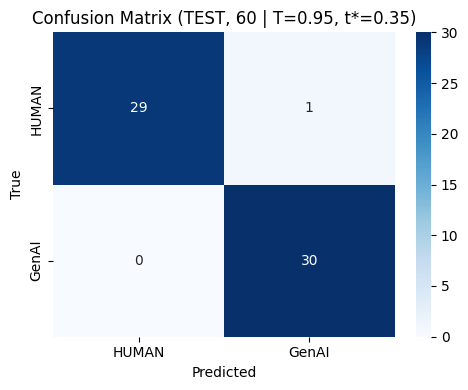


[LOG] Test su dt_test_art&mh.csv — campioni: 60
Accuracy: 0.9833  |  F1 macro: 0.9833  |  Precision macro: 0.9839  |  Recall macro: 0.9833


In [ ]:
TEST_CSV = f"{BASE}/dt_test_art&mh.csv"   # TEST (60)

# Sanity check sui file esistenti
assert os.path.exists(EVAL_CSV), f"File di VALIDATION non trovato: {EVAL_CSV}"
assert os.path.exists(TEST_CSV),  f"File di TEST non trovato: {TEST_CSV}"
print(f"[CHECK] VALIDATION rows = {len(pd.read_csv(EVAL_CSV))}")
print(f"[CHECK] TEST rows       = {len(pd.read_csv(TEST_CSV))}")

# ---------------------------------------------------------
# 1) Calibrazione della temperatura e tuning soglia SU VALIDATION
#    (usa direttamente val_loader, che legge dt_eval_art&mh.csv)
# ---------------------------------------------------------
T_eval = calibrate_temperature(model, val_loader, device)

# scegli la metrica che preferisci per il tuning soglia: "f1_macro" o "balanced_accuracy"
t_eval_star = tune_threshold_on_val(
    model, val_loader, device,
    temperature=T_eval,
    metric="f1_macro"   # <-- cambia in "balanced_accuracy" se vuoi
)

# (Opzionale) override manuale della soglia
if global_var.get("DECISION_THRESHOLD_OVERRIDE") is not None:
    t_eval_star = float(global_var["DECISION_THRESHOLD_OVERRIDE"])

# Riusa il vocab del train (preferisci base_vocab se presente)
vocab_for_eval = globals().get("base_vocab", vocab)

# ---------------------------------------------------------
# 2) Valutazione FINALE su TEST (60) con CM & report
# ---------------------------------------------------------
rep_test, cm_test, n_test = evaluate_csv(
    model, TEST_CSV, vocab=vocab_for_eval,
    label_names=("HUMAN","GenAI"),
    temperature=T_eval, threshold=t_eval_star,
    plot_cm=True, title_suffix=f"(TEST, 60 | T={T_eval:.2f}, t*={t_eval_star:.2f})"
)

print(f"\n[LOG] Test su {os.path.basename(TEST_CSV)} — campioni: {n_test}")
print(
    f"Accuracy: {rep_test['accuracy']:.4f}  |  "
    f"F1 macro: {rep_test['macro avg']['f1-score']:.4f}  |  "
    f"Precision macro: {rep_test['macro avg']['precision']:.4f}  |  "
    f"Recall macro: {rep_test['macro avg']['recall']:.4f}"
)

In [ ]:
# Si rileva BASE, laddove non fosse definita.
if 'BASE' not in locals():
    for _p in ["/content/drive/MyDrive/TESI-Classificazione/MIO",
               "/content/drive/MyDrive/TEST-Classificazione/MIO"]:
        if os.path.isdir(_p):
            BASE = _p
            break

TEST_CSV = f"{BASE}/dt_test_art&mh.csv"
assert os.path.exists(TEST_CSV), f"File non trovato: {TEST_CSV}"

# DATALOADER TEST, RIUSANDO IL VOCAB DEL TRAIN:
test_ds = TextDataset(TEST_CSV, vocab=base_vocab)
test_dl = make_loader(test_ds, batch_size=global_var["batch_size"], shuffle=False)

# INFERENCE CON T_eval E SOGLIA t_eval_star (calibrati su VALIDATION):
probs, preds = [], []
model.eval()
with torch.inference_mode():
    for bx, _ in test_dl:
        logits = model(bx.to(device)) / T_eval
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_eval_star).astype(int).tolist())

# TABELLA ORDINATA (errori in alto) + prob. formattata IT (virgola, 7 decimali)
df_src = pd.read_csv(TEST_CSV)
map_lab = {0: "HUMAN", 1: "GenAI"}
df_out = pd.DataFrame({
    **({"id": df_src["id"]} if "id" in df_src.columns else {}),
    **({"topic": df_src["topic"]} if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),
    "true_id": df_src["label"].astype(int),
    "pred_id": np.array(preds, dtype=int),
    "prob_genai": np.array(probs, dtype=np.float64)
})
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")

def format_it(x: float, decimals: int = 7) -> str:
    return f"{float(x):.{decimals}f}".replace('.', ',')
df_out["prob_genai_it"] = df_out["prob_genai"].map(lambda v: format_it(v, 7))

# ORDINAMENTO: errori prima, poi prob_genai decrescente
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]).drop(columns=["err_rank"])

# PREVIEW COMPLETA (mostra tutte le righe)
pd.set_option("display.max_colwidth", 160)
pd.set_option("display.max_rows", 1000)
display_cols = [c for c in ["id","topic"] if c in df_view.columns] \
             + ["text","true","pred","prob_genai_it","correct"]
print(f"[INFO] TEST — mostro tutte le {len(df_view)} righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols])

# SALVATAGGIO CSV VERSIONATO CON T e t* (formato europeo)
fname = f"test_predictions_art&mh_T{T_eval:.2f}_t{t_eval_star:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8", sep=';', decimal=',')
print("[LOG] File completo salvato in:", save_path)

# SECONDO RIQUADRO: SOLO ERRORI (mostra tutti)
df_errors = df_view[df_view["correct"] == "✗"][display_cols]
print(f"\n[INFO] Errori totali (TEST): {len(df_errors)}\n")
display(df_errors)

[INFO] TEST — mostro tutte le 60 righe (errori in alto). Il file completo viene salvato su Drive.



,text,true,pred,prob_genai_it,correct
47,"Passavo ore su Instagram guardando le vite perfette degli altri. Viaggi da sogno, corpi perfetti, relazioni ideali. La mia vita mi sembrava sempre più grigi...",HUMAN,GenAI,"0,3716297",✗
24,"La Stanza Rossa (Matisse)\nRealizzata nel 1908, l'opera segna l'apice della fase fauve di Matisse. L'artista utilizza il colore puro come elemento struttura...",GenAI,GenAI,"0,9673123",✓
22,"L'Assenzio (Degas)\nDipinto tra il 1875 e il 1876, l'opera rappresenta un esempio della ricerca realista di Degas nell'ambiente urbano parigino. La composiz...",GenAI,GenAI,"0,9644821",✓
6,"Terrazza del Caffè la Sera, Place du Forum, Arles (Van Gogh)\nDipinto nel settembre 1888 durante il soggiorno ad Arles, l'opera rappresenta una delle prime ...",GenAI,GenAI,"0,9631808",✓
16,"Stati d'Animo I: Gli Addii (Boccioni)\nPrimo pannello del trittico realizzato nel 1911, l'opera rappresenta un manifesto del Futurismo italiano. Boccioni ut...",GenAI,GenAI,"0,9524452",✓
26,"New York Movie (Hopper)\nDipinto nel 1939, l'opera esemplifica la poetica hopperiana dell'isolamento urbano. La maschera del cinema, illuminata dalla luce a...",GenAI,GenAI,"0,9468868",✓
38,"Amore e Psiche (Canova)\nScolpita tra il 1787 e il 1793, l'opera rappresenta l'apice del Neoclassicismo europeo. Canova traduce il mito ovidiano in una comp...",GenAI,GenAI,"0,9413224",✓
4,"L'Enigma dell'Ora (De Chirico)\nOpera emblematica della pittura metafisica, realizzata nel 1911, presenta l'iconografia tipica dechirichiana: architetture c...",GenAI,GenAI,"0,9343053",✓
36,"Estasi di Santa Teresa (Bernini)\nRealizzata tra il 1647 e il 1652, la scultura rappresenta l'apice dell'arte barocca. Bernini trasforma il marmo in una vis...",GenAI,GenAI,"0,9281206",✓
28,"Giallo, Rosso, Blu (Kandinsky)\nCompletato nel 1925, il trittico rappresenta una sintesi della teoria artistica di Kandinsky. L'opera esplora la relazione t...",GenAI,GenAI,"0,9265887",✓


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/test_predictions_art&mh_T0.95_t0.35.csv

[INFO] Errori totali (TEST): 1



,text,true,pred,prob_genai_it,correct
47,"Passavo ore su Instagram guardando le vite perfette degli altri. Viaggi da sogno, corpi perfetti, relazioni ideali. La mia vita mi sembrava sempre più grigi...",HUMAN,GenAI,"0,3716297",✗
